In [4]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.data.load_fraud_data import load_fraud_data
from uais.features.fraud_features import build_fraud_feature_table
from uais.supervised.train_fraud_supervised import FraudModelConfig, train_fraud_model
from uais.explainability.shap_explainer import compute_shap_values, plot_shap_summary

from sklearn.model_selection import train_test_split


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [5]:
df_raw = load_fraud_data()
df_feats = build_fraud_feature_table(df_raw, 'Time', 'Amount', 'Class')

target_col = 'Class'
X = df_feats.drop(columns=[target_col])
y = df_feats[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

config = FraudModelConfig(model_type='hist_gb', max_depth=4, learning_rate=0.1, max_iter=200)
model, test_metrics = train_fraud_model(X_train, y_train, X_test, y_test, config)

print('Test metrics:')
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")


Test metrics:
roc_auc: 0.7789
pr_auc: 0.5456
f1: 0.6667
precision: 0.6701
recall: 0.6633
accuracy: 0.9989


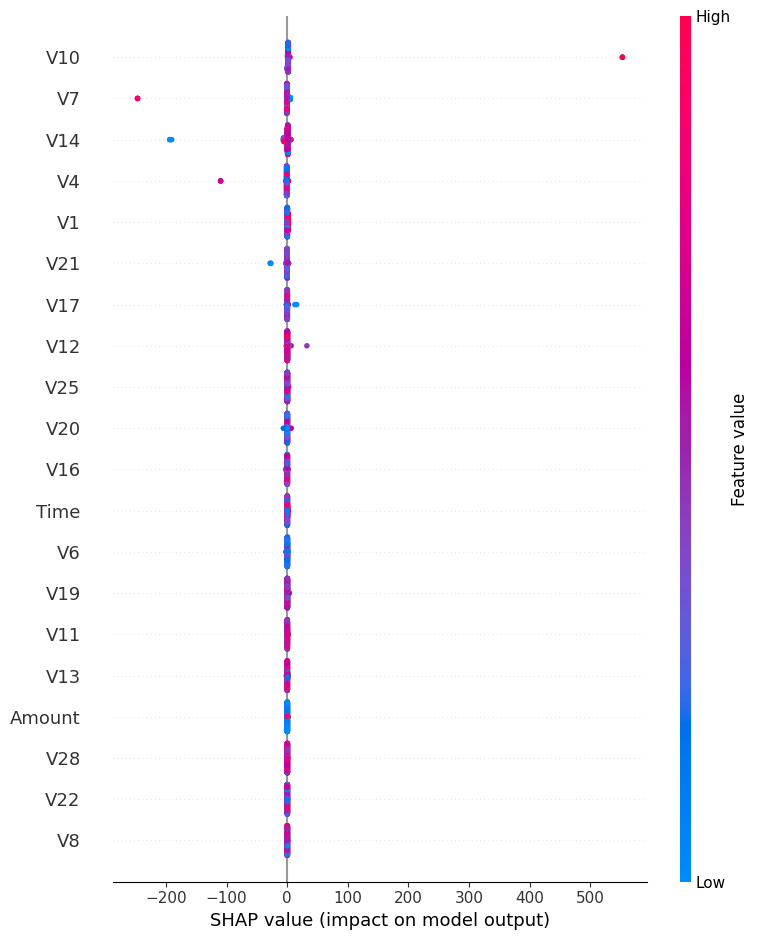

In [6]:
# Use a subset for speed

if 'X' not in globals() or 'y' not in globals():
    df_raw = load_fraud_data()
    df_feats = build_fraud_feature_table(df_raw, 'Time', 'Amount', 'Class')
    target_col = 'Class'
    X = df_feats.drop(columns=[target_col])
    y = df_feats[target_col].astype(int)

if 'X_train' not in globals() or 'X_test' not in globals():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

if 'model' not in globals():
    print('Training a fraud model for explainability preview...')
    retrain_config = FraudModelConfig(model_type='hist_gb', max_depth=4, learning_rate=0.1, max_iter=200)
    model, test_metrics = train_fraud_model(X_train, y_train, X_test, y_test, retrain_config)
    print('Test metrics (auto-trained):')
    for k, v in test_metrics.items():
        print(f"{k}: {v:.4f}")

X_sample = X_test.sample(n=min(500, len(X_test)), random_state=42)
explainer, shap_values = compute_shap_values(model, X_sample)
plot_shap_summary(model, X_sample, max_display=20)
